# Getting Started with supremo_lite

Introduction to core functionality for generating personalized genome sequences and variant-centered windows.

## What is supremo_lite?

supremo_lite is a lightweight Python package for:
- Generating personalized genome sequences from reference genomes and variant files
- Creating variant-centered sequence windows for model predictions
- Performing in-silico saturation mutagenesis
- Aligning predictions across reference and variant sequences

Designed to be memory-efficient and model-agnostic, supporting both PyTorch tensors and NumPy arrays.

## Installation

If you haven't already installed supremo_lite:

```bash
# Install from GitHub (latest release)
pip install git+https://github.com/gladstone-institutes/supremo_lite.git
```

## Basic Imports

In [12]:
import supremo_lite as sl
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
import pandas as pd

print(f"supremo_lite version: {sl.__version__}")

## Optional packages:

# Check PyTorch availability
print(f"PyTorch available: {sl.TORCH_AVAILABLE}")

# Check brisket availability (faster 1h encoding)
print(f"brisket available: {sl.BRISKET_AVAILABLE}")

supremo_lite version: 0.5.4
PyTorch available: True
brisket available: True


## DNA Sequence Encoding

supremo_lite uses one-hot encoding: A=[1,0,0,0], C=[0,1,0,0], G=[0,0,1,0], T=[0,0,0,1]. 

Functions automatically return PyTorch tensors when available, otherwise NumPy arrays.

## Loading Test Data

For this tutorial, we'll use small test data included with the package. This allows for quick demonstrations without requiring large genomic datasets.

In [2]:
import os

# Find the test data directory
# Assuming we're in the package directory structure
test_data_dir = "../../tests/data"

# Load reference genome
reference_path = os.path.join(test_data_dir, "test_genome.fa")
reference = Fasta(reference_path)

print("Reference genome chromosomes:")
for chrom in reference.keys():
    seq_len = len(reference[chrom])
    print(f"  {chrom}: {seq_len} bp")

# Show first 80 bp of chr1
print(f"\nchr1 sequence (first 80 bp):")
print(reference['chr1'][:80].seq)

Reference genome chromosomes:
  chr1: 80 bp
  chr2: 80 bp
  chr3: 80 bp
  chr4: 80 bp
  chr5: 80 bp

chr1 sequence (first 80 bp):
ATGAATATAATATTTTCGAGAATTACTCCTTTTGGAAATGGAACATTATGCGTTTTAAGAGTTTCTGGTAACAATATATT


## Reading VCF Files

supremo_lite provides utilities to read VCF (Variant Call Format) files:

In [3]:
# Load SNP variants
snp_vcf_path = os.path.join(test_data_dir, "snp", "snp.vcf")
snp_variants = sl.read_vcf(snp_vcf_path)

print("SNP variants:")
print(snp_variants)
print(f"\nLoaded {len(snp_variants)} SNP variant(s)")

SNP variants:
  chrom  pos1 id ref alt    info  vcf_line variant_type
0  chr1     2  .   T   G  DP=100         8          SNV
1  chr1    31  .   T   A  DP=100         9          SNV
2  chr2    19  .   A   G  DP=100        10          SNV
3  chr2    57  .   C   G  DP=100        11          SNV

Loaded 4 SNP variant(s)


## Basic Usage: Creating a Personalized Genome

The most fundamental operation is applying variants to a reference genome to create a personalized genome:

In [4]:
# Create personalized genome (returns encoded sequences by default)
personal_genome = sl.get_personal_genome(
    reference_fn=reference,
    variants_fn=snp_variants,
    encode=True,
    verbose=True  # Show progress
)

# Check the result
print(f"\nPersonalized genome chromosomes: {list(personal_genome.keys())}")
print(f"chr1 encoded shape: {personal_genome['chr1'].shape}")
print(f"Data type: {type(personal_genome['chr1'])}")

🧬 Processing 4 variants across 2 chromosomes
   Phase 1: 4 standard variants (SNV, MNV, INS, DEL, SV_DUP, SV_INV)
   Phase 2: 0 BND variants for semantic classification
🔄 Processing chromosome chr1: 2 variants (2 SNV)
  ✅ Applied 2/2 variants (0 skipped)
🔄 Processing chromosome chr2: 2 variants (2 SNV)
  ✅ Applied 2/2 variants (0 skipped)
🧬 Completed: 4/4 variants processed → 5 sequences

Personalized genome chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5']
chr1 encoded shape: torch.Size([80, 4])
Data type: <class 'torch.Tensor'>


## Getting Raw Sequence Strings

You can also get the sequences as strings instead of encoded arrays:

In [5]:
# Get raw sequences
personal_genome_raw = sl.get_personal_genome(
    reference_fn=reference,
    variants_fn=snp_variants,
    encode=False
)

# Compare reference and personalized sequences
ref_seq = reference['chr1'][:80].seq
pers_seq = personal_genome_raw['chr1'][:80]

print("Reference chr1 (first 80 bp):")
print(ref_seq)
print("\nPersonalized chr1 (first 80 bp):")
print(pers_seq)

# Highlight the difference
print("\nDifferences (position: ref → alt):")
for i, (r, p) in enumerate(zip(ref_seq, pers_seq)):
    if r != p:
        print(f"  Position {i}: {r} → {p}")

Reference chr1 (first 80 bp):
ATGAATATAATATTTTCGAGAATTACTCCTTTTGGAAATGGAACATTATGCGTTTTAAGAGTTTCTGGTAACAATATATT

Personalized chr1 (first 80 bp):
AGGAATATAATATTTTCGAGAATTACTCCTATTGGAAATGGAACATTATGCGTTTTAAGAGTTTCTGGTAACAATATATT

Differences (position: ref → alt):
  Position 1: T → G
  Position 30: T → A


## Generating Variant-Centered Windows

Often you want to extract sequence windows centered on each variant, which is useful for model predictions:

In [6]:
# Generate windows around variants
# Note: get_alt_ref_sequences is a generator that yields chunks
results = list(sl.get_alt_ref_sequences(
    reference_fn=reference,
    variants_fn=snp_variants,
    seq_len=40,  # 40 bp windows
    encode=False  # Get strings for visualization
))

# Unpack from the first chunk
alt_seqs, ref_seqs, metadata = results[0]

print(f"Generated {len(metadata)} sequence pair(s)")
print("\nMetadata:")
print(metadata.head())  # Show first few variants

print("\nReference sequence (2nd variant):")
print(ref_seqs[1])
print("\nAlternate sequence (2nd variant):")
print(alt_seqs[1])

# Find the variant position in the window
variant_offset = len(ref_seqs[1][3]) // 2
print(f"\nVariant is centered at position {variant_offset} in the window")
print(f"Reference allele: {ref_seqs[1][3][variant_offset]}")
print(f"Alternate allele: {alt_seqs[1][3][variant_offset]}")

Generated 4 sequence pair(s)

Metadata:
  chrom  window_start  window_end  variant_pos0  variant_pos1 ref alt  \
0  chr1             0          40             1             2   T   G   
1  chr1            10          50            30            31   T   A   
2  chr2             0          40            18            19   A   G   
3  chr2            36          76            56            57   C   G   

  variant_type  
0          SNV  
1          SNV  
2          SNV  
3          SNV  

Reference sequence (2nd variant):
('chr1', np.int64(10), np.int64(50), 'TATTTTCGAGAATTACTCCTTTTGGAAATGGAACATTATG')

Alternate sequence (2nd variant):
('chr1', np.int64(10), np.int64(50), 'TATTTTCGAGAATTACTCCTATTGGAAATGGAACATTATG')

Variant is centered at position 20 in the window
Reference allele: T
Alternate allele: A


## Sequence Utilities

supremo_lite provides useful utilities for working with DNA sequences:

In [9]:
# Reverse complement
sequence = "ATCGATCG"
rc_sequence = sl.rc_str(sequence)

print(f"Original:          {sequence}")
print(f"Reverse complement: {rc_sequence}")

# Encode and decode
encoded = sl.encode_seq(sequence) # Automatically uses brisket if installed
decoded = sl.decode_seq(encoded)

print(f"\nDecoded matches original: {decoded == sequence}")

# Reverse complement of encoded sequence
rc_encoded = sl.rc(encoded)
rc_decoded = sl.decode_seq(rc_encoded)

print(f"RC from encoded:   {rc_decoded}")
print(f"RC from string:    {rc_sequence}")
print(f"Match: {rc_decoded == rc_sequence}")

Original:          ATCGATCG
Reverse complement: CGATCGAT

Decoded matches original: True
RC from encoded:   CGATCGAT
RC from string:    CGATCGAT
Match: True


## Working with Encoded Sequences

Let's see how to work with encoded sequences for downstream analysis:

Reference sequences shape: torch.Size([4, 40, 4])
Alternate sequences shape: torch.Size([4, 40, 4])
Data type: <class 'torch.Tensor'>


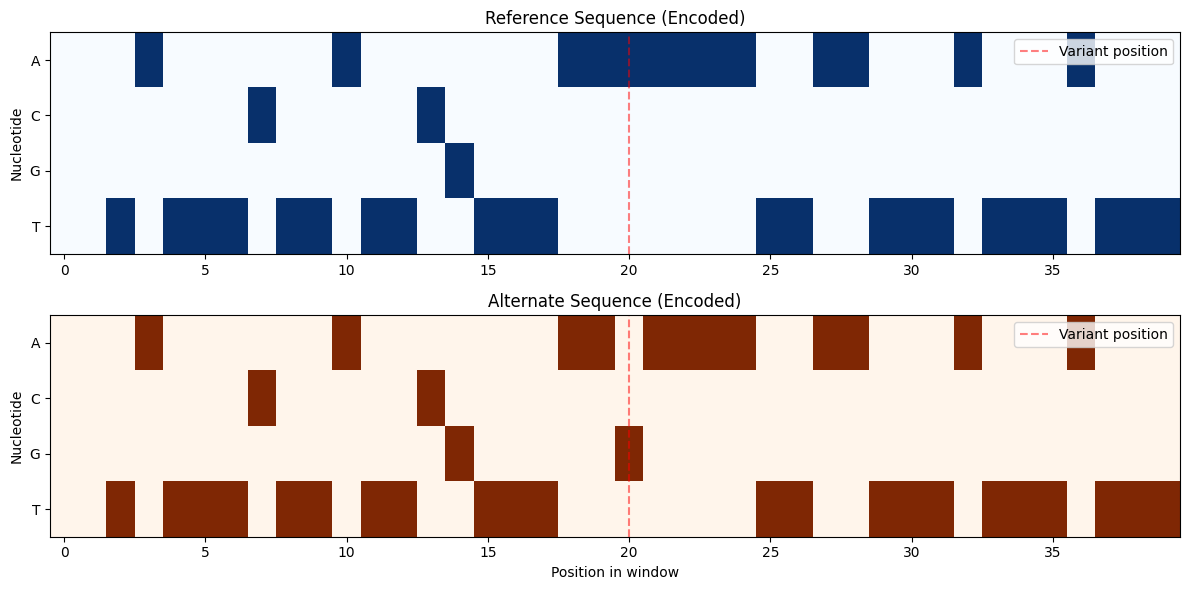


The variant at position 20 shows different encoding between ref and alt


In [11]:
# Generate encoded windows
results = list(sl.get_alt_ref_sequences(
    reference_fn=reference,
    variants_fn=snp_variants,
    seq_len=40,
    encode=True  # Get encoded arrays/tensors
))

# Unpack from the first chunk
alt_seqs_enc, ref_seqs_enc, metadata = results[0]

print(f"Reference sequences shape: {ref_seqs_enc.shape}")
print(f"Alternate sequences shape: {alt_seqs_enc.shape}")
print(f"Data type: {type(ref_seqs_enc)}")

# Visualize the first sequence pair
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Reference sequence
im1 = ax1.imshow(ref_seqs_enc[2].T, cmap='Blues', aspect='auto')
ax1.set_yticks([0, 1, 2, 3])
ax1.set_yticklabels(['A', 'C', 'G', 'T'])
ax1.set_title('Reference Sequence (Encoded)')
ax1.set_ylabel('Nucleotide')
ax1.axvline(x=20, color='red', linestyle='--', alpha=0.5, label='Variant position')
ax1.legend()

# Alternate sequence
im2 = ax2.imshow(alt_seqs_enc[2].T, cmap='Oranges', aspect='auto')
ax2.set_yticks([0, 1, 2, 3])
ax2.set_yticklabels(['A', 'C', 'G', 'T'])
ax2.set_title('Alternate Sequence (Encoded)')
ax2.set_xlabel('Position in window')
ax2.set_ylabel('Nucleotide')
ax2.axvline(x=20, color='red', linestyle='--', alpha=0.5, label='Variant position')
ax2.legend()

plt.tight_layout()
plt.show()

print("\nThe variant at position 20 shows different encoding between ref and alt")


## Next Steps

Continue with the other notebooks:
- **[02_personalized_genomes.ipynb](02_personalized_genomes.ipynb)** - Genome personalization workflows
- **[03_prediction_alignment.ipynb](03_prediction_alignment.ipynb)** - Model predictions and alignment